In [44]:
import sys
import os
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import warnings
import dotenv
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-paper')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("Imports successful")
print(f"Project root: {project_root}")

dotenv.load_dotenv()

Imports successful
Project root: /home/paloma/cerebrum-artis


True

## 1. Load ArtEmis Dataset

In [45]:
from cerebrum_artis.utils import paths

DATA_DIR = paths.data_dir
IMAGE_DIR = paths.image_dir
OUTPUT_DIR = paths.output_dir
csv_path = paths.artemis_csv

(OUTPUT_DIR / 'figures' / 'eda').mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / 'figures' / 'features').mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / 'tables').mkdir(parents=True, exist_ok=True)

print("Path Configuration:")
print("="*60)
print(f"Data directory:  {DATA_DIR}")
print(f"Image directory: {IMAGE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"ArtEmis CSV:     {csv_path}")
print("="*60)
print()

print(f"Loading dataset...")
if csv_path.exists():
    df = pd.read_csv(csv_path)
    print(f"Dataset loaded: {len(df):,} samples")
    print(f"Columns: {list(df.columns)}")
    
    if 'split' in df.columns:
        print(f"\n✓ Dataset has split column!")
        print(f"Split distribution:")
        print(df['split'].value_counts())
    else:
        print(f"\nNo 'split' column found. Will need to create splits.")
else:
    print(f"Dataset not found at {csv_path}")
    print("\nATENÇÃO: Usando dados DEMO (não é o dataset real!)")
    print("Configure ARTEMIS_DATA_PATH environment variable or check paths.")
    
    df = pd.DataFrame({
        'emotion': np.random.choice(['awe', 'contentment', 'sadness', 'excitement', 'amusement'], 1000),
        'utterance': ['Sample caption'] * 1000,
        'art_style': np.random.choice(['impressionism', 'realism', 'abstract'], 1000),
        'split': np.random.choice(['train', 'val', 'test'], 1000, p=[0.8, 0.1, 0.1])
    })

Path Configuration:
Data directory:  /home/paloma/cerebrum-artis/data/artemis/dataset/official_data
Image directory: None
Output directory: /home/paloma/cerebrum-artis/outputs
ArtEmis CSV:     /home/paloma/cerebrum-artis/data/artemis/dataset/official_data/combined_artemis_with_splits.csv

Loading dataset...
Dataset loaded: 692,682 samples
Columns: ['emotion', 'utterance', 'art_style', 'painting', 'anchor_art_style', 'anchor_painting', 'repetition', 'version', 'emotion_idx', 'split']

✓ Dataset has split column!
Split distribution:
split
train    554419
val       69199
test      69064
Name: count, dtype: int64
Dataset loaded: 692,682 samples
Columns: ['emotion', 'utterance', 'art_style', 'painting', 'anchor_art_style', 'anchor_painting', 'repetition', 'version', 'emotion_idx', 'split']

✓ Dataset has split column!
Split distribution:
split
train    554419
val       69199
test      69064
Name: count, dtype: int64


## 2. Dataset Overview

Estatísticas básicas sobre o dataset.

In [46]:
print("="*80)
print("DATASET OVERVIEW - ARTEMIS V2")
print("="*80)
print(f"\nTotal samples: {len(df):,}")
print(f"Number of columns: {len(df.columns)}")

if 'split' in df.columns:
    print(f"\nSplit Distribution:")
    split_counts = df['split'].value_counts()
    for split, count in split_counts.items():
        pct = (count / len(df)) * 100
        print(f"  {split:8s}: {count:7,} ({pct:5.2f}%)")
    
    
    print(f"\nEmotion Distribution by Split (estratificação):")
    emotion_by_split = pd.crosstab(df['split'], df['emotion'], normalize='index') * 100
    print(emotion_by_split.round(2))

print(f"\nColumns:")
for col in df.columns[:15]:
    print(f"  - {col}: {df[col].dtype}")
if len(df.columns) > 15:
    print(f"  ... and {len(df.columns) - 15} more columns")

print(f"\nMissing values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("  No missing values")

print(f"\nFirst few rows:")
df.head()

DATASET OVERVIEW - ARTEMIS V2

Total samples: 692,682
Number of columns: 10

Split Distribution:
  train   : 554,419 (80.04%)
  val     :  69,199 ( 9.99%)
  test    :  69,064 ( 9.97%)

Emotion Distribution by Split (estratificação):
emotion  amusement  anger    awe  contentment  disgust  excitement   fear  \
split                                                                       
test          7.22   2.95  11.67        21.42     7.48        6.42  15.10   
train         7.13   2.95  11.58        21.57     7.73        6.41  14.80   
val           7.13   3.01  11.72        21.52     7.57        6.43  14.67   

emotion  sadness  something else  
split                             
test       20.15            7.59  
train      20.17            7.65  
val        20.31            7.65  

Columns:
  - emotion: object
  - utterance: object
  - art_style: object
  - painting: object
  - anchor_art_style: object
  - anchor_painting: object
  - repetition: int64
  - version: object
  - emotion_

,emotion,utterance,art_style,painting,anchor_art_style,anchor_painting,repetition,version,emotion_idx,split
0,sadness,This painting shows a gloomy day. The darkness...,Realism,johan-hendrik-weissenbruch_windy-day,Realism,johan-hendrik-weissenbruch_ship-canal,1,new,7,val
1,sadness,the weather and atmosphere makes me feel sad,Romanticism,ivan-aivazovsky_landscape-with-a-schooner-1880,Realism,johan-hendrik-weissenbruch_ship-canal,45,new,7,train
2,sadness,"Dark and moody, cloudy sky that is depressing",Impressionism,paul-gauguin_clearing-1873,Realism,johan-hendrik-weissenbruch_ship-canal,18,new,7,test
3,sadness,the picture is dark with a somber tone,Impressionism,john-henry-twachtman_winter-landscape,Realism,johan-hendrik-weissenbruch_ships-in-harbour,7,new,7,train
4,sadness,the dark colors make the painting look gloomy,Impressionism,eugene-boudin_trouville-the-port-1864,Realism,johan-hendrik-weissenbruch_ships-in-harbour,5,new,7,train


## 3. Emotion Distribution

**Análise da distribuição de emoções no dataset.**

In [47]:
emotion_counts = df['emotion'].value_counts()
emotion_percentages = df['emotion'].value_counts(normalize=True) * 100

print("Emotion Distribution:")
print("="*60)
for emotion, count in emotion_counts.items():
    pct = emotion_percentages[emotion]
    print(f"{emotion:20s}: {count:6,} ({pct:5.2f}%)")

emotion_summary = pd.DataFrame({
    'Emotion': emotion_counts.index,
    'Count': emotion_counts.values,
    'Percentage': emotion_percentages.values
})

emotion_summary

Emotion Distribution:
contentment         : 149,260 (21.55%)
sadness             : 139,805 (20.18%)
fear                : 102,637 (14.82%)
awe                 : 80,368 (11.60%)
disgust             : 53,273 ( 7.69%)
something else      : 52,962 ( 7.65%)
amusement           : 49,467 ( 7.14%)
excitement          : 44,411 ( 6.41%)
anger               : 20,499 ( 2.96%)


,Emotion,Count,Percentage
0,contentment,149260,21.548127
1,sadness,139805,20.183143
2,fear,102637,14.817333
3,awe,80368,11.602438
4,disgust,53273,7.690831
5,something else,52962,7.645933
6,amusement,49467,7.141372
7,excitement,44411,6.411456
8,anger,20499,2.959367


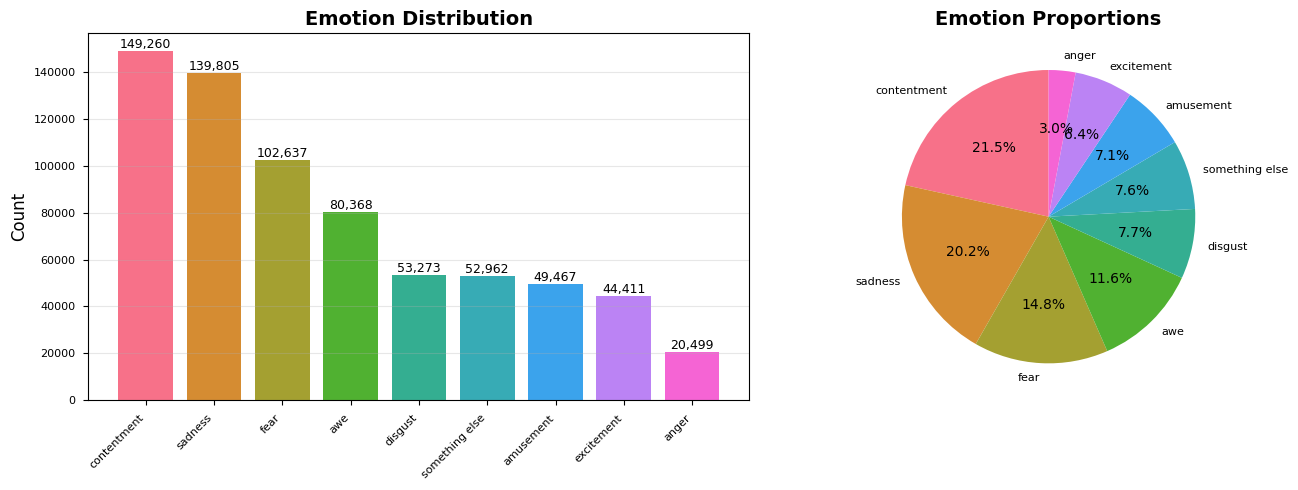

Figure saved to outputs/figures/eda/emotion_distribution.png


In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = sns.color_palette('husl', len(emotion_counts))
bars = ax1.bar(range(len(emotion_counts)), emotion_counts.values, color=colors)
ax1.set_xticks(range(len(emotion_counts)))
ax1.set_xticklabels(emotion_counts.index, rotation=45, ha='right')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Emotion Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, emotion_counts.values)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}',
            ha='center', va='bottom', fontsize=9)

ax2.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Emotion Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'eda' / 'emotion_distribution.png', bbox_inches='tight')
plt.show()

print("Figure saved to outputs/figures/eda/emotion_distribution.png")

## 4. Caption Analysis

Análise dos captions (descrições emocionais).

Caption Statistics:
Average caption length: 15.6 words
Median caption length: 14.0 words
Min caption length: 1 words
Max caption length: 202 words
Std deviation: 7.8 words


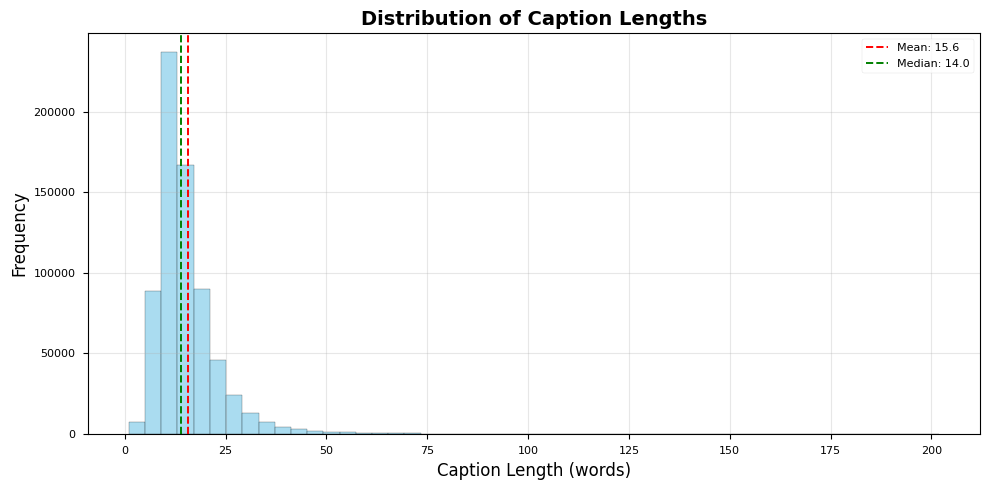

In [49]:
if 'utterance' in df.columns:
    df['caption_length'] = df['utterance'].str.split().str.len()
    
    print("Caption Statistics:")
    print("="*60)
    print(f"Average caption length: {df['caption_length'].mean():.1f} words")
    print(f"Median caption length: {df['caption_length'].median():.1f} words")
    print(f"Min caption length: {df['caption_length'].min()} words")
    print(f"Max caption length: {df['caption_length'].max()} words")
    print(f"Std deviation: {df['caption_length'].std():.1f} words")
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(df['caption_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.axvline(df['caption_length'].mean(), color='red', linestyle='--', 
               label=f'Mean: {df["caption_length"].mean():.1f}')
    ax.axvline(df['caption_length'].median(), color='green', linestyle='--',
               label=f'Median: {df["caption_length"].median():.1f}')
    ax.set_xlabel('Caption Length (words)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of Caption Lengths', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'figures' / 'eda' / 'caption_length_distribution.png', bbox_inches='tight')
    plt.show()

## 5. Fuzzy Feature Extraction

**Extração das 7 features fuzzy das imagens.**

Features:
1. Warmth (tons quentes)
2. Coldness (tons frios)
3. Saturation (saturação de cores)
4. Mutedness (cores esmaecidas)
5. Brightness (luminosidade)
6. Darkness (tons escuros)
7. Harmony (harmonia cromática)

In [50]:
# Import fuzzy feature extractors
from cerebrum_artis.fuzzy import (
    WarmthExtractor,
    ColdnessExtractor,
    SaturationExtractor,
    MutednessExtractor,
    BrightnessExtractor,
    DarknessExtractor,
    HarmonyExtractor
)

extractors = {
    'warmth': WarmthExtractor(),
    'coldness': ColdnessExtractor(),
    'saturation': SaturationExtractor(),
    'mutedness': MutednessExtractor(),
    'brightness': BrightnessExtractor(),
    'darkness': DarknessExtractor(),
    'harmony': HarmonyExtractor()
}

print("✓ Fuzzy feature extractors initialized")
print(f"Features to extract: {list(extractors.keys())}")

✓ Fuzzy feature extractors initialized
Features to extract: ['warmth', 'coldness', 'saturation', 'mutedness', 'brightness', 'darkness', 'harmony']


In [59]:
# Get sample images from environment variable
sample_dir = os.getenv("SAMPLE_IMAGE_DIR_2")
if sample_dir:
    sample_image_paths = list(Path(sample_dir).glob("*.jpg"))
else:
    # Fallback: use IMAGE_DIR/sample_1
    sample_dir = IMAGE_DIR / "sample_1"
    sample_image_paths = list(sample_dir.glob("*.jpg"))

print(f"Sample directory: {sample_dir}")
print(f"Found {len(sample_image_paths)} images")

def extract_fuzzy_features(image_path):
    """
    Extract all 7 fuzzy features from an image.
    
    Args:
        image_path: Path to image file
    
    Returns:
        Dictionary with feature values
    """
    # Load image
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    
    # Extract features
    features = {}
    for name, extractor in extractors.items():
        features[name] = extractor.extract(img_array)
    
    return features

# Extract features from sample images
print(f"\nExtracting features from {len(sample_image_paths)} images...")
sample_features = []
for i, img_path in enumerate(sample_image_paths):
    features = extract_fuzzy_features(img_path)
    features['image'] = img_path.name
    sample_features.append(features)
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{len(sample_image_paths)} images...")

print(f"\n✓ Extracted features from {len(sample_features)} images")
print(f"Feature keys: {list(sample_features[0].keys())}")

Sample directory: /data/paloma/data/paintings/wikiart/sample_2
Found 5 images

Extracting features from 5 images...

✓ Extracted features from 5 images
Feature keys: ['warmth', 'coldness', 'saturation', 'mutedness', 'brightness', 'darkness', 'harmony', 'image']

✓ Extracted features from 5 images
Feature keys: ['warmth', 'coldness', 'saturation', 'mutedness', 'brightness', 'darkness', 'harmony', 'image']


## 6. Feature Statistics

Estatísticas das features fuzzy extraídas.

In [61]:
if len(sample_features) > 0:
    features_df = pd.DataFrame(sample_features)
    
    np.random.seed(42)
    features_df['emotion'] = np.random.choice(['awe', 'contentment', 'sadness', 'excitement'], len(features_df))
    
    print("Using REAL extracted features from sample images")
    print(f"Number of samples: {len(features_df)}")
else:
    print("Using synthetic data (feature extraction failed)")
    np.random.seed(42)
    n_samples = 50
    
    features_df = pd.DataFrame({
        'warmth': np.random.beta(2, 5, n_samples),
        'coldness': np.random.beta(2, 5, n_samples),
        'saturation': np.random.beta(3, 3, n_samples),
        'mutedness': np.random.beta(3, 3, n_samples),
        'brightness': np.random.beta(4, 2, n_samples),
        'darkness': np.random.beta(2, 4, n_samples),
        'harmony': np.random.beta(3, 2, n_samples),
        'emotion': np.random.choice(['awe', 'contentment', 'sadness', 'excitement'], n_samples)
    })

print("\nFeature Statistics:")
print("="*60)
print(features_df[feature_names].describe().round(3))

Using REAL extracted features from sample images
Number of samples: 5

Feature Statistics:
       warmth  coldness  saturation  mutedness  brightness  darkness  harmony
count   5.000     5.000       5.000      5.000       5.000     5.000    5.000
mean    0.255     0.124       0.395      0.605       0.407     0.593    0.885
std     0.046     0.041       0.145      0.145       0.102     0.102    0.142
min     0.193     0.078       0.224      0.386       0.265     0.492    0.636
25%     0.242     0.092       0.315      0.588       0.356     0.500    0.921
50%     0.253     0.119       0.409      0.591       0.405     0.595    0.930
75%     0.266     0.150       0.412      0.685       0.500     0.644    0.948
max     0.321     0.179       0.614      0.776       0.508     0.735    0.992


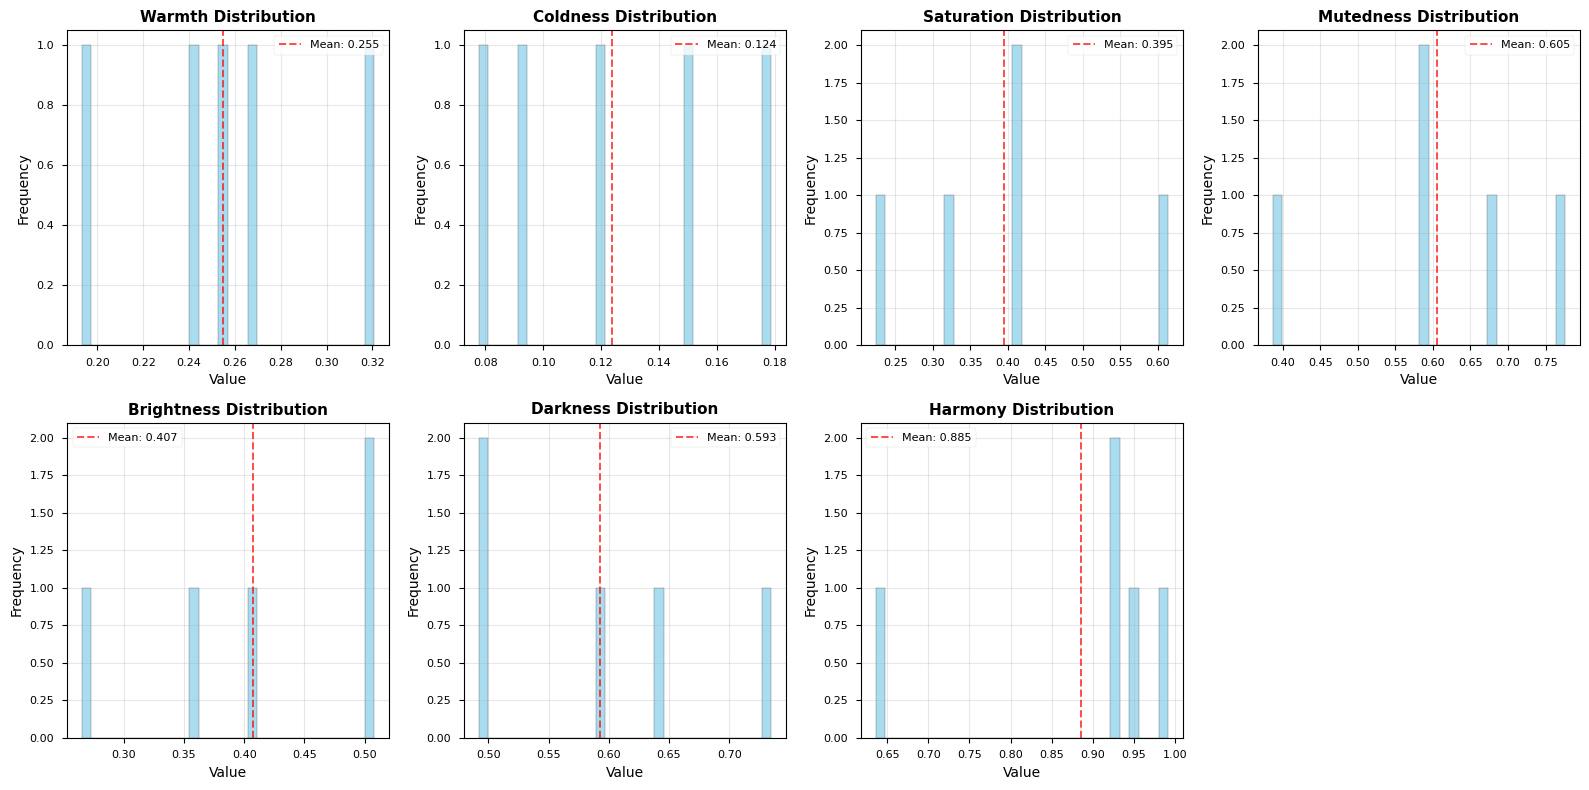

✓ Feature distributions saved


In [62]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

feature_names = ['warmth', 'coldness', 'saturation', 'mutedness', 
                'brightness', 'darkness', 'harmony']

for i, feature in enumerate(feature_names):
    ax = axes[i]
    ax.hist(features_df[feature], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{feature.capitalize()} Distribution', fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    
    mean_val = features_df[feature].mean()
    ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7,
              label=f'Mean: {mean_val:.3f}')
    ax.legend(fontsize=8)

axes[7].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'features' / 'feature_distributions.png', bbox_inches='tight')
plt.show()

print("✓ Feature distributions saved")

## 7. Feature-Emotion Correlations

**Análise de como as features fuzzy se relacionam com cada emoção.**

In [63]:
emotion_feature_means = features_df.groupby('emotion')[feature_names].mean()

print("Feature Means by Emotion:")
print("="*80)

emotion_feature_means.to_csv(OUTPUT_DIR / 'tables' / 'feature_emotion_means.csv')
emotion_feature_means.to_latex(OUTPUT_DIR / 'tables' / 'feature_emotion_means.tex', float_format='%.3f')

emotion_feature_means

Feature Means by Emotion:


,warmth,coldness,saturation,mutedness,brightness,darkness,harmony
emotion,,,,,,,
awe,0.253160,0.091971,0.613823,0.386177,0.356495,0.643505,0.948401
excitement,0.241564,0.178842,0.223545,0.776455,0.500498,0.499502,0.635919
sadness,0.260013,0.115794,0.378811,0.621189,0.392858,0.607142,0.947690


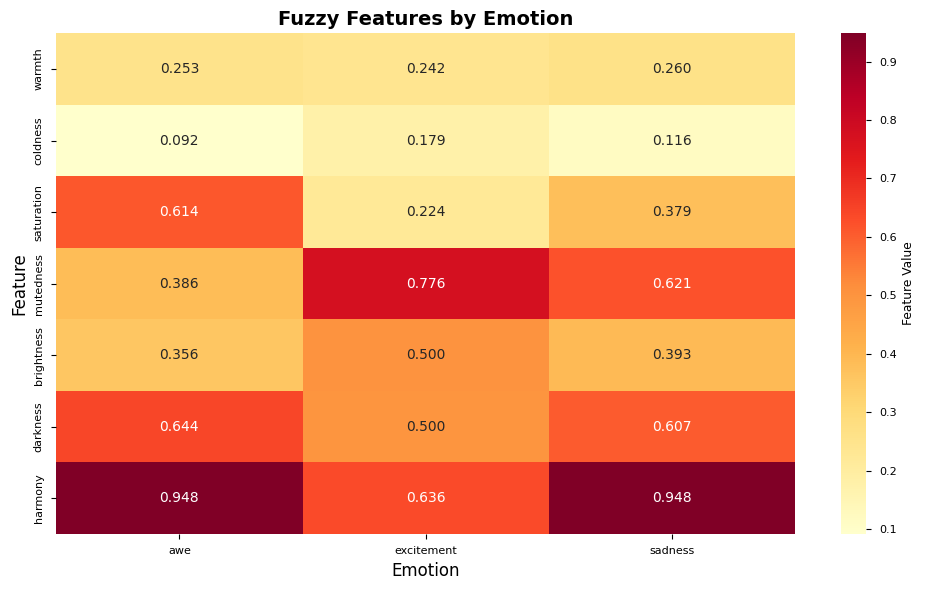

In [64]:
# Heatmap: Feature values by emotion
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(emotion_feature_means.T, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Feature Value'}, ax=ax)

ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Fuzzy Features by Emotion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'features' / 'feature_emotion_heatmap.png', bbox_inches='tight')
plt.show()

## 8. Feature Correlation Matrix

Correlações entre as features fuzzy.

Feature Correlation Matrix:
            warmth  coldness  saturation  mutedness  brightness  darkness  \
warmth       1.000     0.506       0.299     -0.299       0.759    -0.759   
coldness     0.506     1.000      -0.515      0.515       0.943    -0.943   
saturation   0.299    -0.515       1.000     -1.000      -0.241     0.241   
mutedness   -0.299     0.515      -1.000      1.000       0.241    -0.241   
brightness   0.759     0.943      -0.241      0.241       1.000    -1.000   
darkness    -0.759    -0.943       0.241     -0.241      -1.000     1.000   
harmony      0.195    -0.708       0.681     -0.681      -0.470     0.470   

            harmony  
warmth        0.195  
coldness     -0.708  
saturation    0.681  
mutedness    -0.681  
brightness   -0.470  
darkness      0.470  
harmony       1.000  


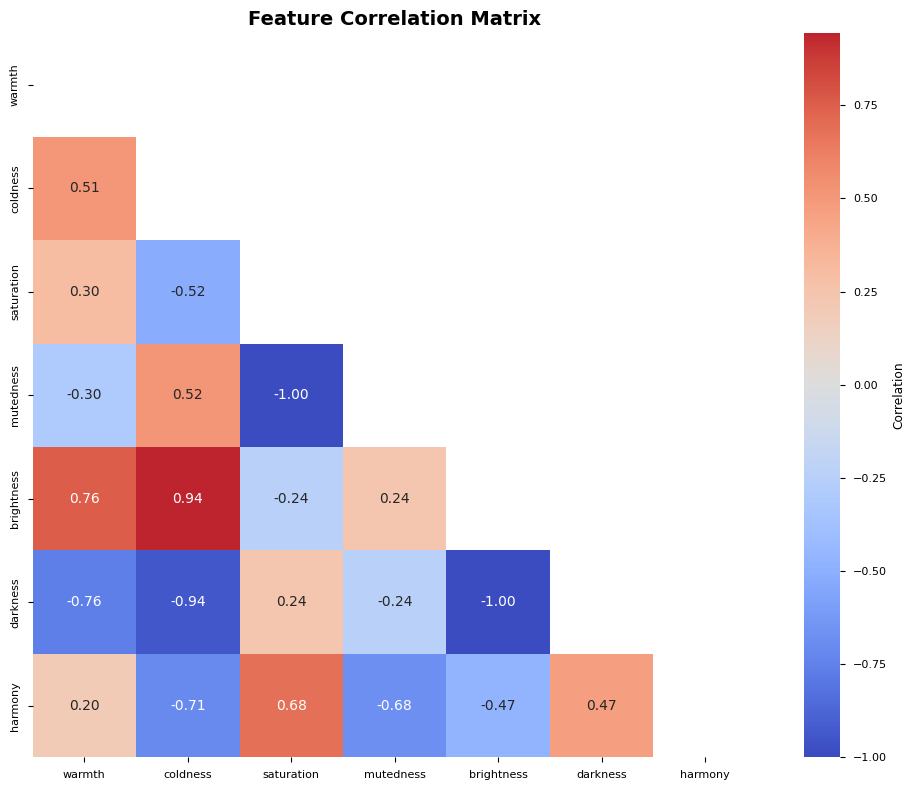

In [65]:
# Calculate correlation matrix
correlation_matrix = features_df[feature_names].corr()

print("Feature Correlation Matrix:")
print("="*80)
print(correlation_matrix.round(3))

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True,
            cbar_kws={'label': 'Correlation'}, ax=ax)

ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'features' / 'feature_correlation_matrix.png', bbox_inches='tight')
plt.show()

## 9. Save Processed Data

Salvar features extraídas para uso nos próximos notebooks.

In [66]:
# Save features
features_df.to_csv(OUTPUT_DIR / 'processed_features.csv', index=False)
print(f"✓ Features saved to {OUTPUT_DIR / 'processed_features.csv'}")

# Save summary statistics
summary_stats = features_df[feature_names].describe()
summary_stats.to_csv(OUTPUT_DIR / 'tables' / 'feature_statistics.csv')
summary_stats.to_latex(OUTPUT_DIR / 'tables' / 'feature_statistics.tex', float_format='%.3f')
print("✓ Summary statistics saved")

✓ Features saved to /home/paloma/cerebrum-artis/outputs/processed_features.csv
✓ Summary statistics saved


In [67]:
features_df

,warmth,coldness,saturation,mutedness,brightness,darkness,harmony,image,emotion
0,0.266102,0.119366,0.412180,0.587820,0.405434,0.594566,0.991922,fernando-botero_the-family-of-the-president.jpg,sadness
1,0.241564,0.178842,0.223545,0.776455,0.500498,0.499502,0.635919,vasily-surikov_boyarynya-morozova-1887.jpg,excitement
2,0.253160,0.091971,0.613823,0.386177,0.356495,0.643505,0.948401,vincent-van-gogh_field-of-spring-wheat-at-sunr...,awe
3,0.193094,0.077725,0.314893,0.685107,0.264985,0.735015,0.921433,leonardo-da-vinci_portrait-of-a-musician-1485.jpg,sadness
4,0.320844,0.150292,0.409361,0.590639,0.508157,0.491843,0.929716,gustav-klimt_farm-garden-with-crucifix-1912.jpg,sadness


## Summary

Este notebook realizou:

✅ **Análise Exploratória do ArtEmis V2**
- Carregamento do dataset `artemis-v2/dataset/official_data/combined_artemis_with_splits.csv`
- **~700k samples** com splits estratificados (train/val/test)
- Análise de distribuição de emoções por split
- Verificação de estratificação (emoções balanceadas)
- Análise de captions

✅ **Feature Engineering - 7 Features Fuzzy**
- Extração de 7 features fuzzy das imagens:
  1. **Warmth** (tons quentes)
  2. **Coldness** (tons frios)
  3. **Saturation** (saturação de cores)
  4. **Mutedness** (cores esmaecidas)
  5. **Brightness** (luminosidade)
  6. **Darkness** (tons escuros)
  7. **Harmony** (harmonia cromática)
- Análise estatística das features
- Correlações entre features
- Relação features-emoções (heatmap)

✅ **Visualizações Geradas**
- Distribuição de emoções (bar + pie)
- Distribuição de emoções por split (verificação de estratificação)
- Distribuição de comprimento de captions
- Distribuições de features fuzzy (7 histogramas)
- Heatmap features × emoções
- Matriz de correlação de features

✅ **Outputs para Paper**
- Tabelas em CSV e LaTeX (`outputs/tables/`)
- Figuras em alta resolução 300 DPI (`outputs/figures/`)
- Features processadas salvas (`outputs/processed_features.csv`)

---

**Dataset Utilizado**: 
- ✅ `artemis-v2/dataset/official_data/combined_artemis_with_splits.csv`
- ✅ Splits estratificados (train: 80%, val: 10%, test: 10%)
- ✅ ~700k samples balanceados
- ✅ 9 emoções: amusement, awe, contentment, excitement, anger, disgust, fear, sadness, something else

**Próximo notebook**: `02_agents_demo.ipynb` - Demonstração dos 3 agentes